导入需要的包

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import eli5
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,auc
import shap


定义混淆矩阵绘制函数

In [2]:
def cnf_matrix_plotter(cm,classes):
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Oranges)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    threshold=cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                 horizontalalignment="center",
                 color="white" if cm[i,j]>threshold else "black",
                 fontsize=25)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

读取数据并过滤警告提示

In [3]:
warnings.filterwarnings("ignore")
df= pd.read_csv("E:/22-23第二学期/大数据概论/process_heart1025.csv")
X=df.drop('target',axis=1)
y=df['target']
display(X)
display(y)

age  trestbps  chol  thalach  oldpeak  ca  sex_female  sex_male  \
0      52       125   212      168      1.0   2           0         1   
1      53       140   203      155      3.1   0           0         1   
2      70       145   174      125      2.6   0           0         1   
3      61       148   203      161      0.0   1           0         1   
4      62       138   294      106      1.9   3           1         0   
...   ...       ...   ...      ...      ...  ..         ...       ...   
1020   59       140   221      164      0.0   0           0         1   
1021   60       125   258      141      2.8   1           0         1   
1022   47       110   275      118      1.0   1           0         1   
1023   50       110   254      159      0.0   0           1         0   
1024   54       120   188      113      1.4   1           0         1   

      cp_asymptomatic  cp_atypical angina  ...  restecg_normal  exang_no  \
0                   0                   0  ...               0         1   
1                   0                   0  ...               1         0   
2                   0                   0  ...               0         0   
3                   0                   0  ...               0         1   
4                   0                   0  ...               0         1   
...               ...                 ...  ...             ...       ...   
1020                0                   1  ...               0         0   
1021                0                   0  ...               1         0   
1022                0                   0  ...               1         0   
1023                0                   0  ...               1         1   
1024                0                   0  ...               0         1   

      exang_yes  slope_downsloping  slope_flat  slope_upsloping  \
0             0                  1           0                0   
1             1                  0           0                1   
2             1                  0           0                1   
3             0                  1           0                0   
4             0                  0           1                0   
...         ...                ...         ...              ...   
1020          1                  1           0                0   
1021          1                  0           1                0   
1022          1                  0           1                0   
1023          0                  1           0                0   
1024          0                  0           1                0   

      thal_fixed defect  thal_normal  thal_reversable defect  thal_unknown  
0                     0            0                       1             0  
1                     0            0                       1             0  
2                     0            0                       1             0  
3                     0            0                       1             0  
4                     1            0                       0             0  
...                 ...          ...                     ...           ...  
1020                  1            0                       0             0  
1021                  0            0                       1             0  
1022                  1            0                       0             0  
1023                  1            0                       0             0  
1024                  0            0                       1             0  

[1025 rows x 26 columns]

0       0
1       0
2       0
3       0
4       0
       ..
1020    1
1021    0
1022    0
1023    1
1024    0
Name: target, Length: 1025, dtype: int64

构建随机森林模型，其中设置最大深度为5，弱分类器数量为100，随机扰动状态设定为5（为了使每次生成的森林均不相同）

In [4]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=10);
RandomForestClassifier
model=RandomForestClassifier(max_depth=5,n_estimators=100,random_state=5)
model.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, random_state=5)

挑选随机森林中的索引为7决策树进行可视化操作

In [5]:
feature_names=X_train.columns
estimator=model.estimators_[7]
display(estimator)
#将特征值转换为字符串
y_train_str=y_train.astype('str')
y_train_str[y_train_str=='0']='no disease'
y_train_str[y_train_str=='1']='disease'
y_train_str=y_train_str.values
export_graphviz(estimator,out_file='tree.dot',feature_names=feature_names,class_names=y_train_str,rounded=True,proportion=True,label='root',precision=2,filled=True)

DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                       random_state=2059200585)

In [6]:
#call(['dot','-Tpng','tree.dot','-o','tree.png'])   该命令需要在anaconda prompt中执行

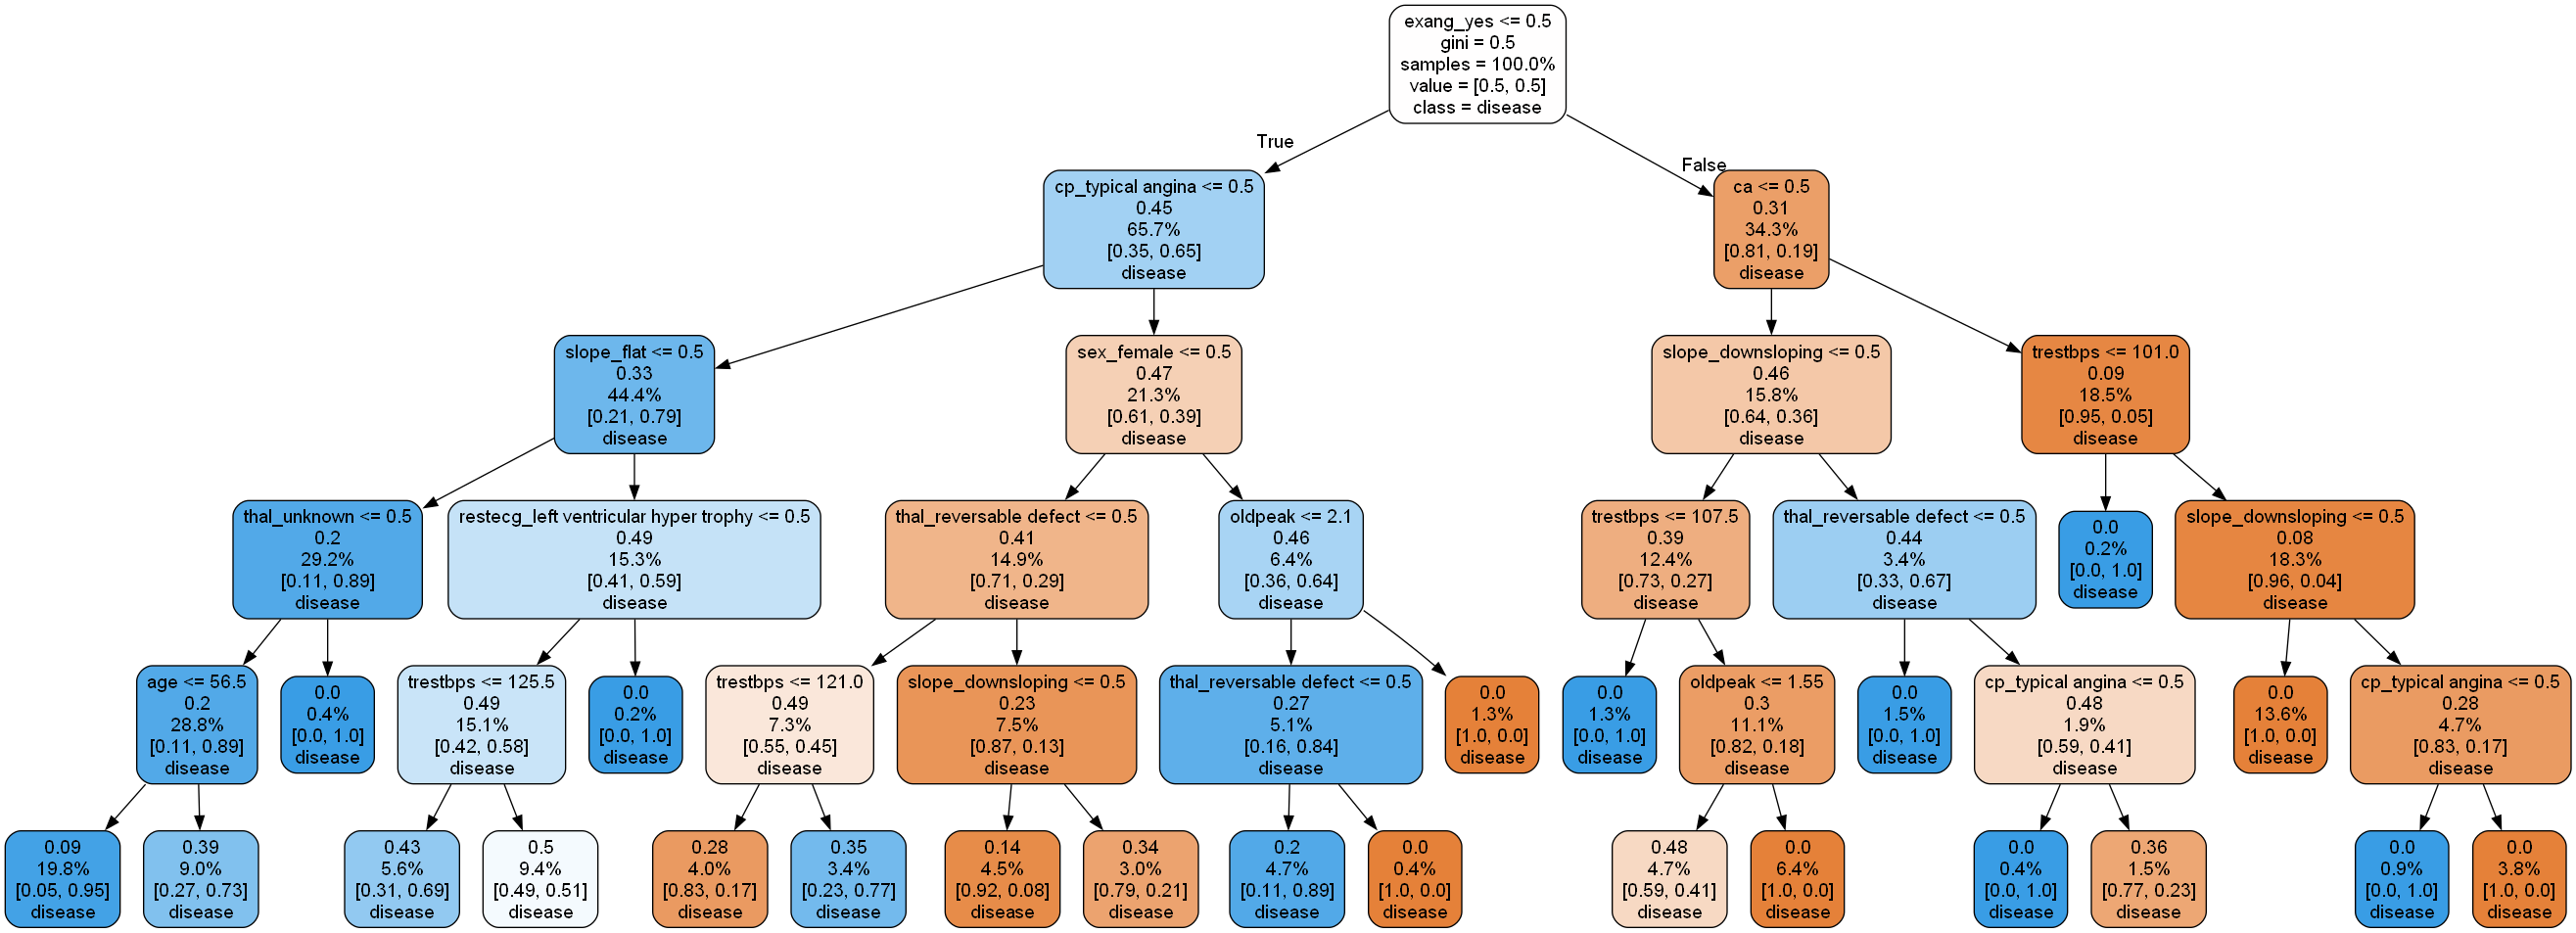

导入eli5包绘制各指标权重图

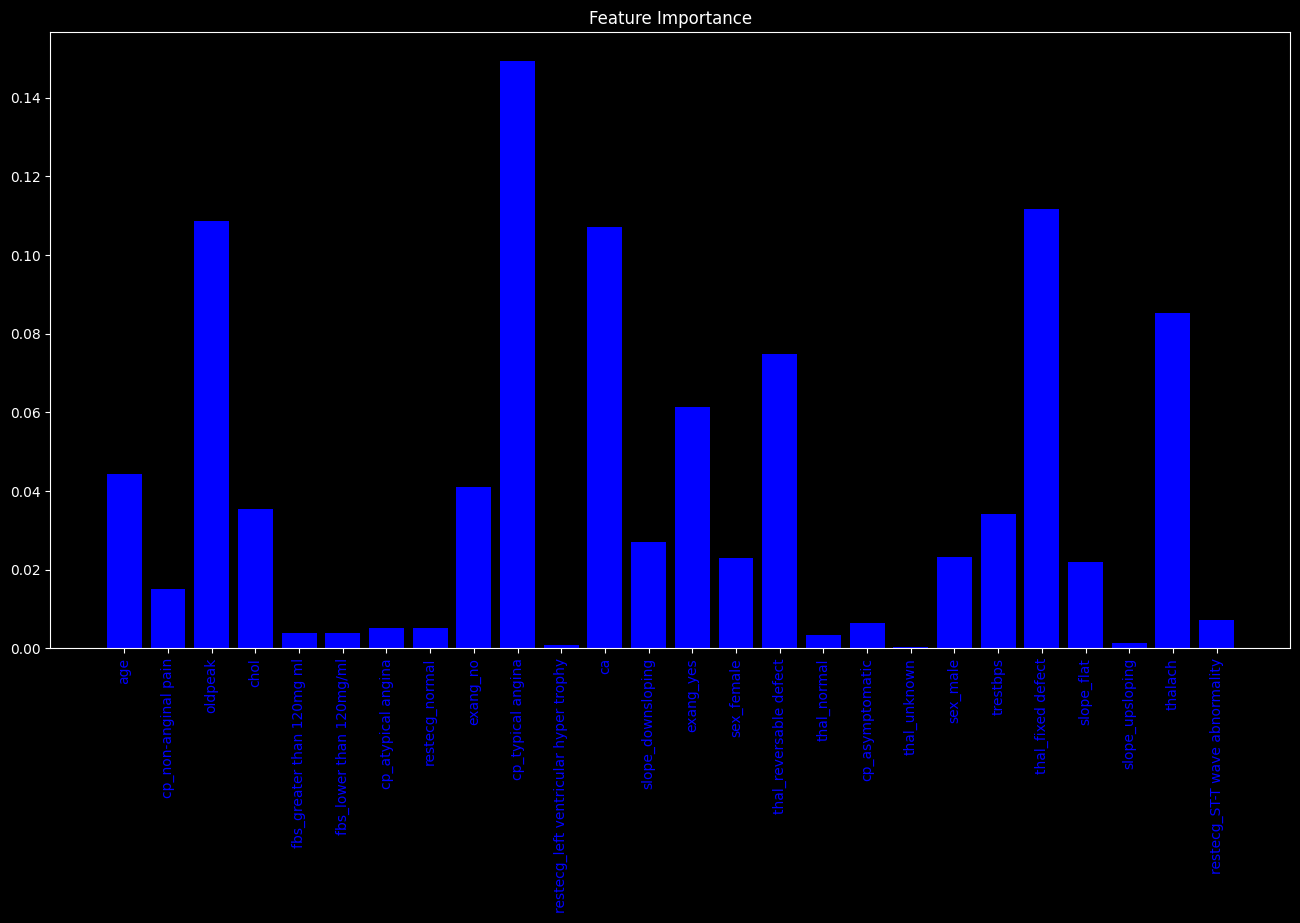

In [6]:
eli5.show_weights(estimator,feature_names=feature_names.tolist())
feature_importances=model.feature_importances_
indices=np.argsort(feature_importances[::-1])
plt.figure(figsize=(16,8))
plt.title('Feature Importance')
plt.bar(range(len(feature_importances)),feature_importances[indices],color='b')
plt.xticks(range(len(feature_importances)),np.array(feature_names)[indices],color='b',rotation=90)
plt.show()

绘制混淆矩阵以及ROC值

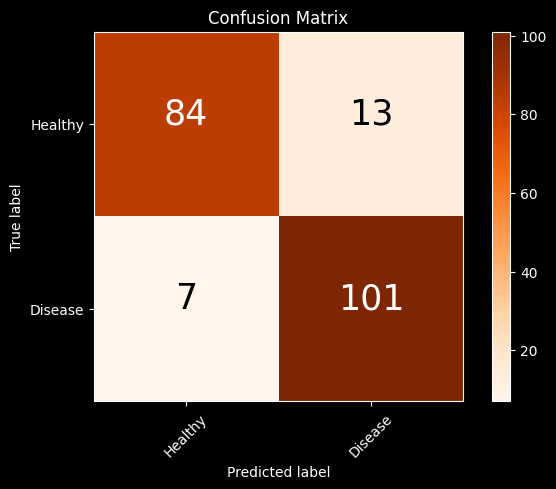

              precision    recall  f1-score   support

     Healthy       0.92      0.87      0.89        97
     Disease       0.89      0.94      0.91       108

    accuracy                           0.90       205
   macro avg       0.90      0.90      0.90       205
weighted avg       0.90      0.90      0.90       205



In [7]:
test_sample=X_test.iloc[2]
test_sample=np.array(test_sample).reshape(1,-1)
y_pred=model.predict(X_test)
y_pred_proba=model.predict_proba(X_test)
confusion_matrix_model=confusion_matrix(y_test,y_pred)
cnf_matrix_plotter(confusion_matrix_model, ['Healthy','Disease'])
print(classification_report(y_test, y_pred,target_names=['Healthy','Disease']))
y_pred_quant=model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds=roc_curve(y_test, y_pred_quant)

绘制ROC曲线

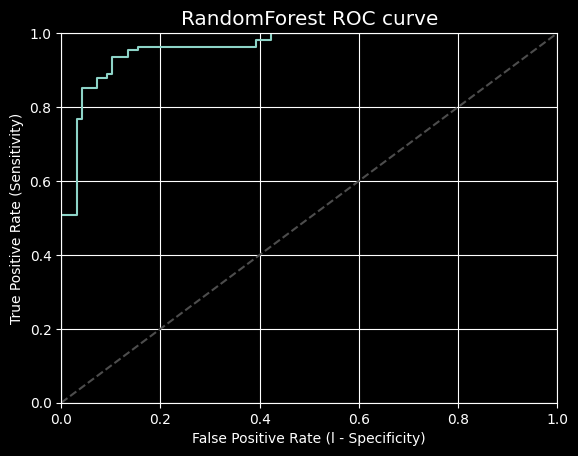

In [8]:
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],ls="--",c=".3")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.rcParams['font.size'] = 12
plt.title('RandomForest ROC curve')
plt.xlabel('False Positive Rate (l - Specificity)')
plt.ylabel( 'True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()

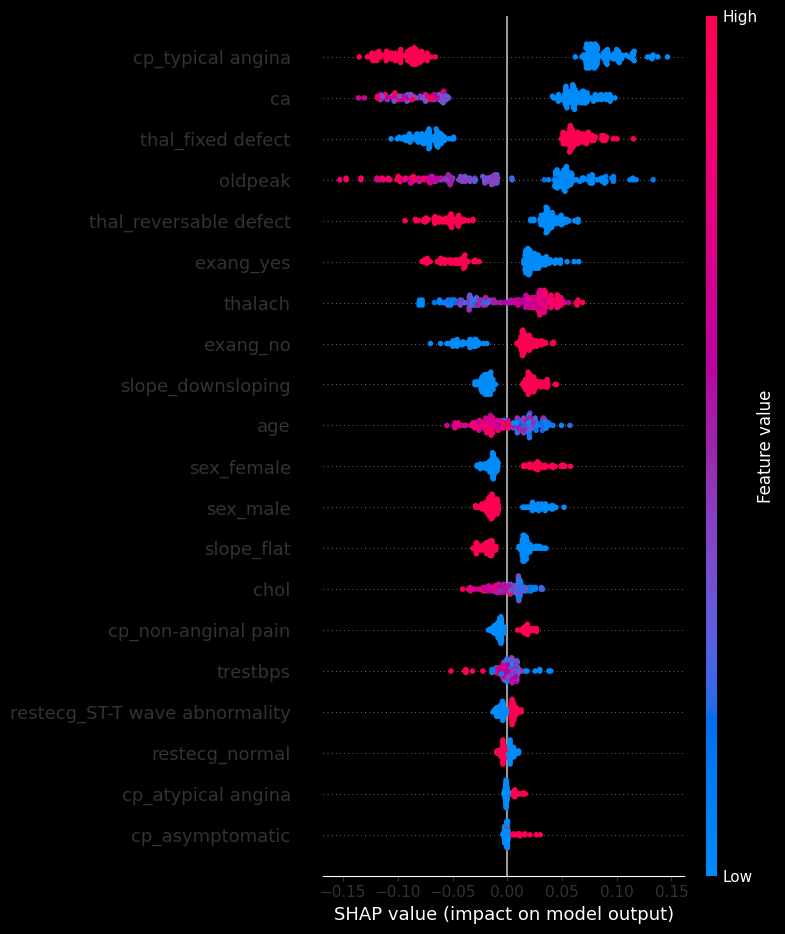

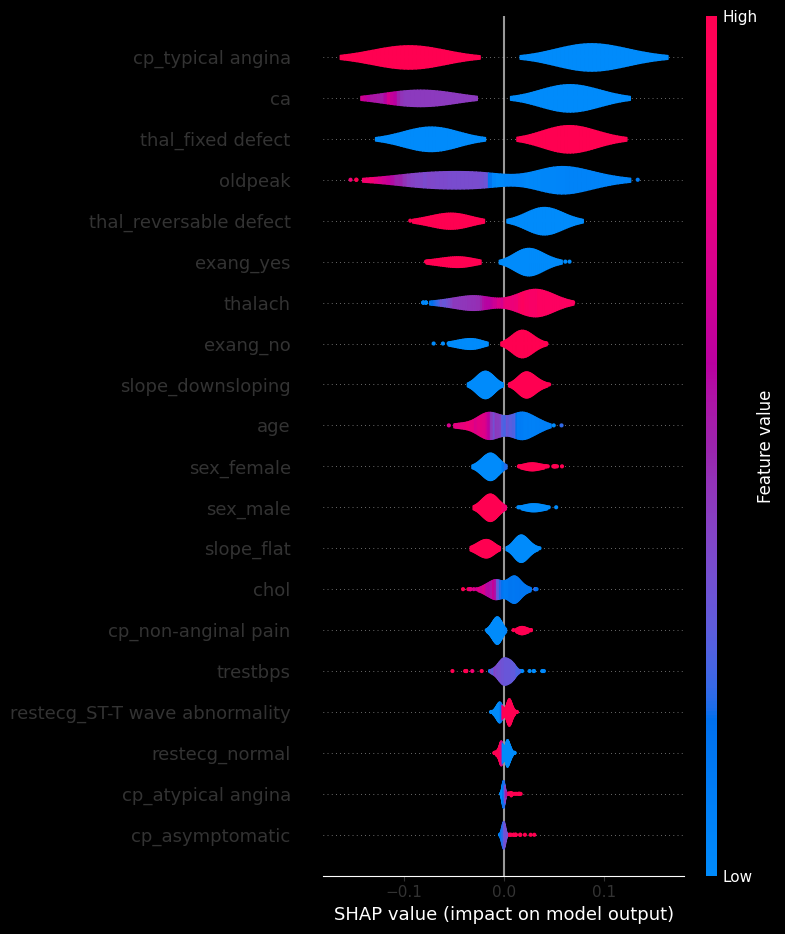

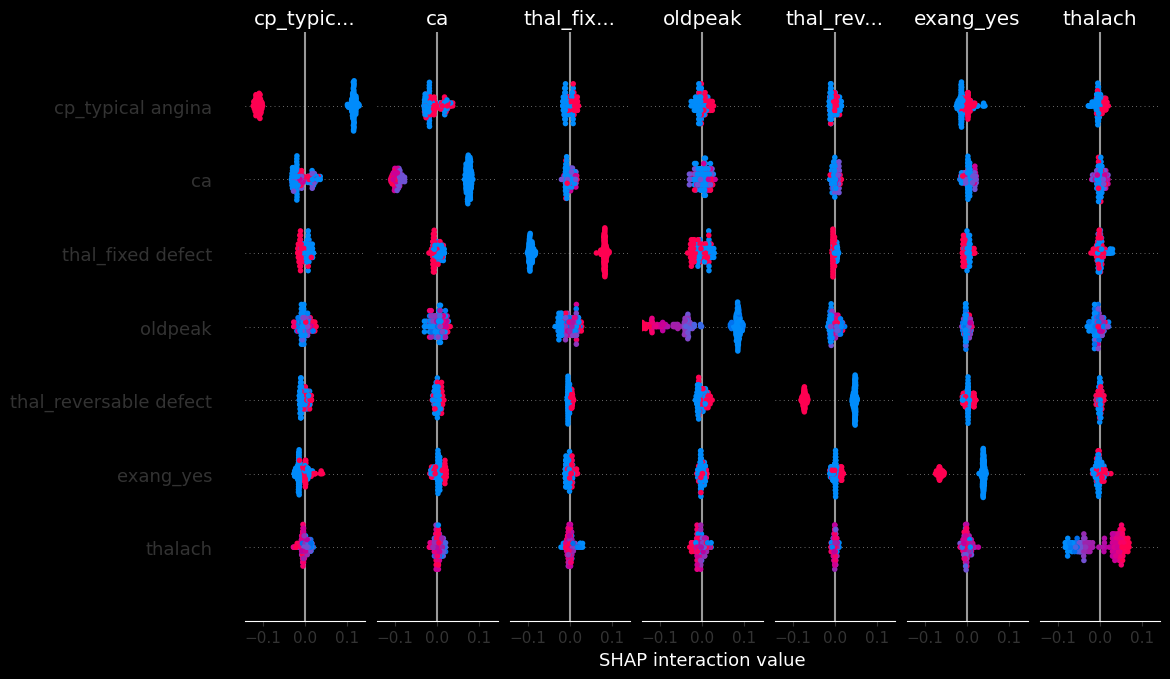

In [11]:
shap.initjs()
explainer=shap.TreeExplainer(model)
shap_values=explainer.shap_values(X_test)
shap.summary_plot(shap_values[1],X_test)
shap.summary_plot(shap_values[1],X_test,plot_type="violin")
shap_interaction_values=explainer.shap_interaction_values(X_test)
shap.summary_plot(shap_interaction_values[1],X_test)

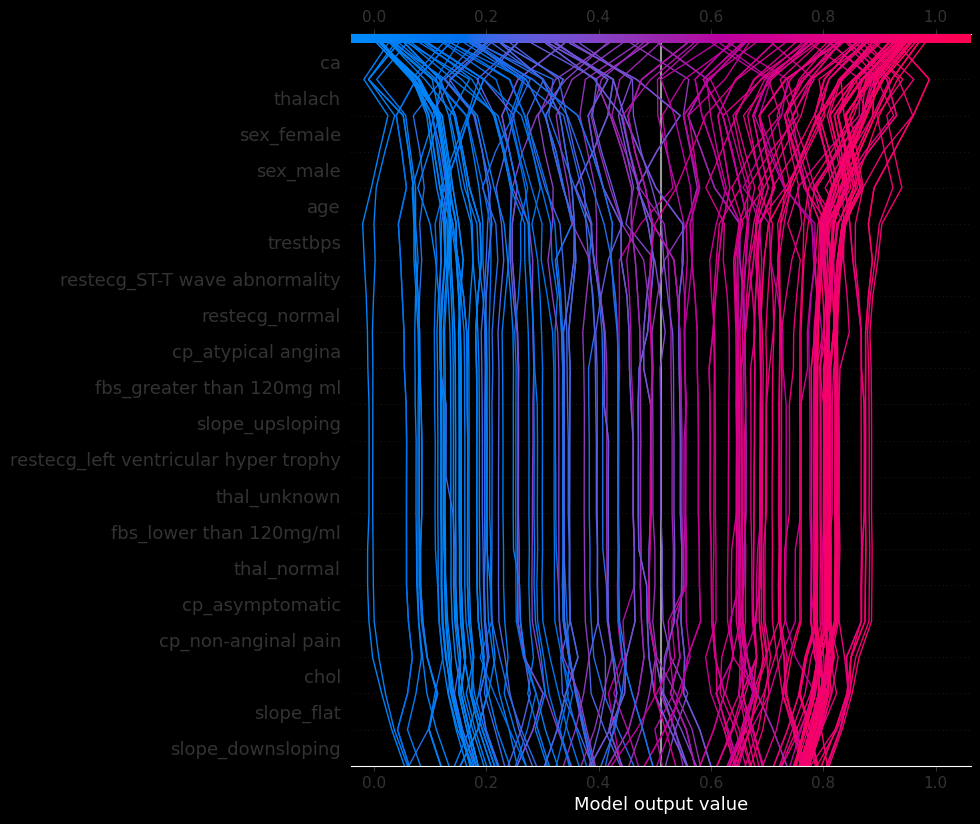

In [13]:
expected_value=explainer.expected_value
shap.decision_plot(expected_value[1],shap_values[1],X_test,feature_order='hclust')

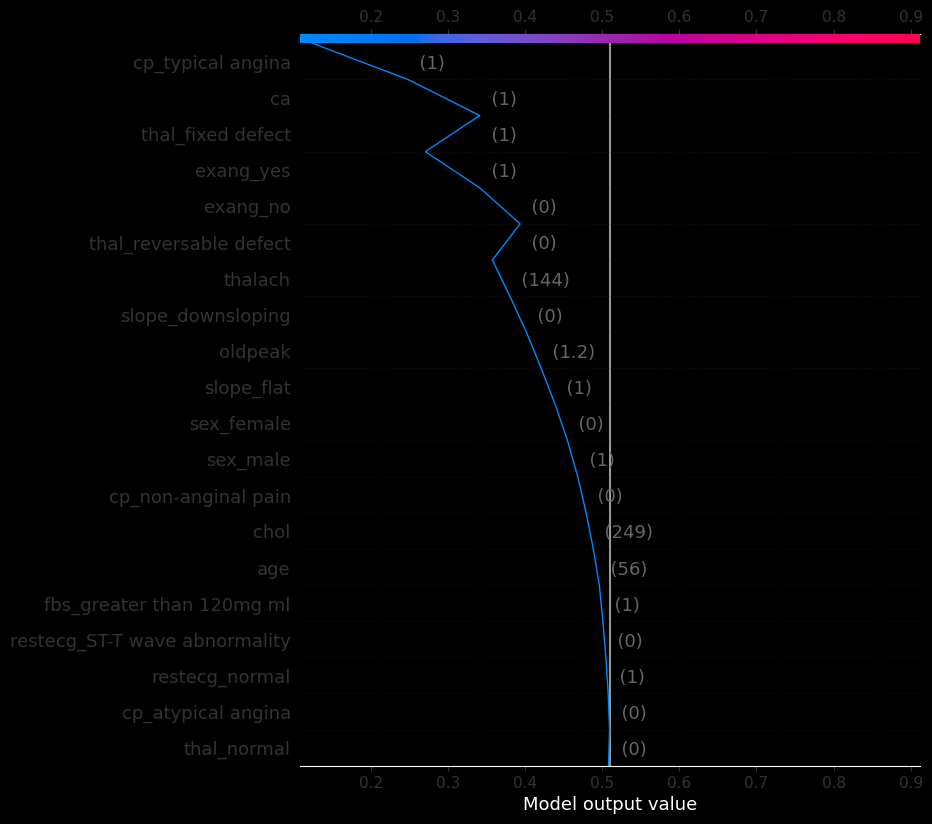

In [22]:
idx=12
selection=np.zeros((205))
selection[idx]=1
selection=selection>0
shap.decision_plot(expected_value[1],shap_values[1][selection],X_test[selection])

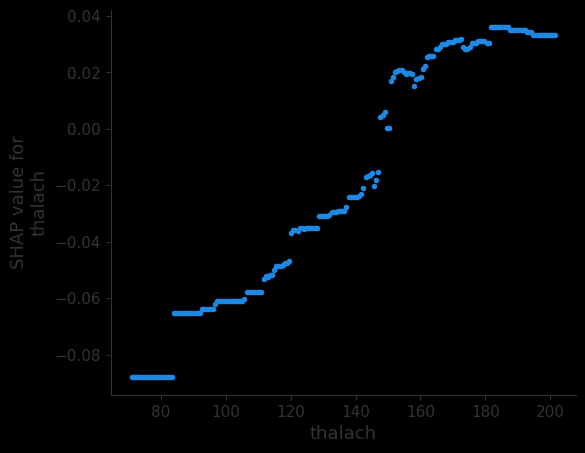

In [25]:
feature_selected = 'thalach'
sep = 200
feature_selected_min =X[feature_selected].min()
feature_selected_max=X[feature_selected].max()
step=(feature_selected_max-feature_selected_min)/sep
rg=np.arange(feature_selected_min,feature_selected_max,step)
R=X.iloc[np.repeat(idx,len(rg))].reset_index(drop=True)
R[feature_selected]=rg
hypothetical_shap_values=explainer.shap_values(R)[1]
shap.dependence_plot(feature_selected,hypothetical_shap_values,R,interaction_index=None)

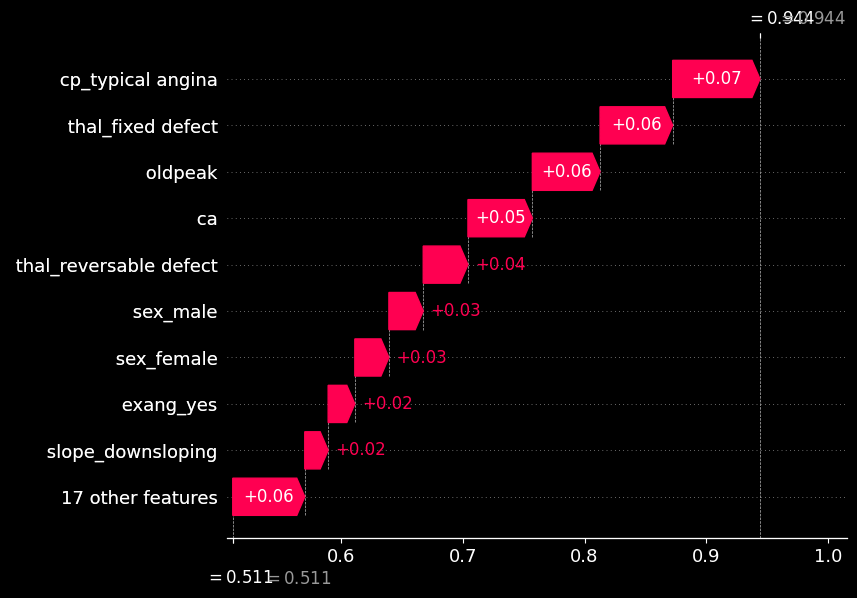

In [31]:
from shap.plots import _waterfall
idx=np.argpartition(shap_values[1][:,X_test.columns.get_loc('oldpeak')],2)
idx=5
patient=X_test.iloc[idx,:]
shap_values_patient=explainer.shap_values(patient)
_waterfall.waterfall_legacy(explainer.expected_value[1],shap_values_patient[1],patient)

In [11]:
#选取测试集中编号为126的病人
idx=126
patient=X.iloc[idx,:]
shap_values_patient=explainer.shap_values(patient)
#展示了某个病人从测试集平均结果到最终预测结果的决策过程，以及各特征对预测结果的贡献影响
shap.force_plot(explainer.expected_value[1],shap_values_patient[1],patient)

In [12]:
#再选取测试集中编号为166的病人（不患病）
idx=166
patient=X.iloc[idx,:]
shap_values_patient=explainer.shap_values(patient)
#展示了某个病人从测试集平均结果到最终预测结果的决策过程，以及各特征对预测结果的贡献影响
shap.force_plot(explainer.expected_value[1],shap_values_patient[1],patient)